<a href="https://colab.research.google.com/github/deepu718/tensorflow_practice/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning with TensorFlow Part 3: Scaling up (Food vision mini)

We've seen the power of transfer learning feature extraction and fine tuning, now it's time to scale up to all of tje classes in Food101.

Our goal is to beat the oringnal Food101 paper with 10% of the training data leveraging the power of deep learning.

our baseline to beat is 50.76% accuracy 101 classes.

## Creating helper functions

In previous notebook we created a series of helper function to do different tasks

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-20 13:32:30--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-08-20 13:32:30 (118 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
# Import series of helper function for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir


## 101 food classes: working with less data

our goal is to beat the orignal Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the orignal Food101 dataset but has been preprocessed

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train"
test_dir = "101_food_classes_10_percent/test"

--2023-08-20 13:32:35--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.128, 173.194.211.128, 173.194.212.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  90.0MB/s    in 17s     

2023-08-20 13:32:52 (90.7 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
# How many image classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/red_velvet_cake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/clam_chowder'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fish_and_chips'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ravioli'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/mussels'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/paella'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_roll_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 imag

In [5]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode = "categorical",
                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                 label_mode = "categorical",
                                                                 image_size=IMG_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:
* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation to the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [6]:
# Create a checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callbac = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                        save_weights_only = True,
                                                        monitor="val_accuracy",
                                                        save_best_only=True)

In [7]:
# Create a data augmentation layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
],name="data_augmentation")

In [8]:
# Setup the base model and freeze its layer (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224,224,3),name="Input_layer")
x = data_augmentation(inputs)
x = base_model(x,training = False)
x = layers.GlobalAveragePooling2D(name="global_pool_layer")(x)
outputs = layers.Dense(len(train_data.class_names),activation="softmax",name="output_layer")(x)
model = tf.keras.Model(inputs,outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_pool_layer (GlobalAv  (None, 1280)             0         
 eragePooling2D)                                                 
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [10]:
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_1 = model.fit(train_data,
                      epochs=5,
                      validation_data=test_data,
                      validation_steps=int(0.15*len(test_data)),
                      callbacks=[checkpoint_callbac])

Epoch 1/5
237/237 [==============================] - 119s 434ms/step - loss: 3.3916 - accuracy: 0.2712 - val_loss: 2.4486 - val_accuracy: 0.4542
Epoch 2/5
237/237 [==============================] - 75s 315ms/step - loss: 2.2046 - accuracy: 0.4941 - val_loss: 2.0128 - val_accuracy: 0.5151
Epoch 3/5
237/237 [==============================] - 67s 281ms/step - loss: 1.8328 - accuracy: 0.5670 - val_loss: 1.8280 - val_accuracy: 0.5408
Epoch 4/5
237/237 [==============================] - 59s 244ms/step - loss: 1.6127 - accuracy: 0.6107 - val_loss: 1.7462 - val_accuracy: 0.5498
Epoch 5/5
237/237 [==============================] - 58s 244ms/step - loss: 1.4493 - accuracy: 0.6430 - val_loss: 1.6881 - val_accuracy: 0.5567


In [11]:
# Evaluate on the whole test dataset
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 [==============================] - 59s 75ms/step - loss: 1.5676 - accuracy: 0.5874


[1.5676333904266357, 0.5874455571174622]

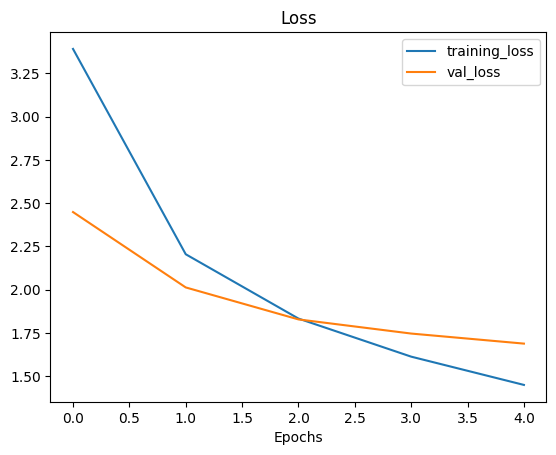

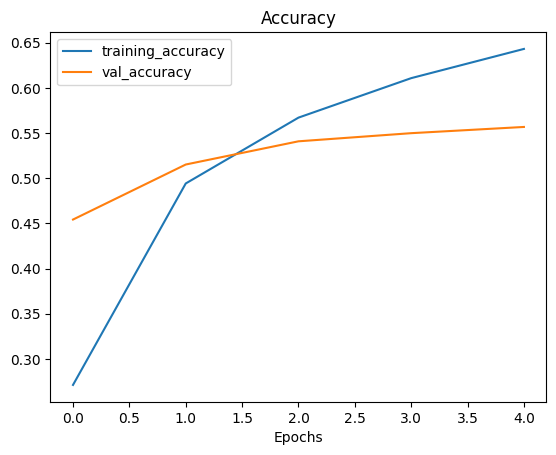

In [12]:
plot_loss_curves(history_1)

## Fine Tuning

In [13]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [14]:
# Recompile model with lower learning rate it is the best practice to lower the learning rate when fine-tuning
model.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [15]:
for layer in model.layers:
  print(layer.name, layer.trainable)

Input_layer True
data_augmentation True
efficientnetb0 True
global_pool_layer True
output_layer True


In [17]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10
history_1_fine_tune = model.fit(train_data,
                                epochs=fine_tune_epochs,
                                validation_data=test_data,
                                validation_steps=0.15 * len(test_data),
                                initial_epoch=history_1.epoch[-1])

Epoch 5/10
237/237 [==============================] - 70s 251ms/step - loss: 1.2152 - accuracy: 0.6793 - val_loss: 1.6926 - val_accuracy: 0.5517
Epoch 6/10
237/237 [==============================] - 51s 212ms/step - loss: 1.0961 - accuracy: 0.7053 - val_loss: 1.6751 - val_accuracy: 0.5612
Epoch 7/10
237/237 [==============================] - 51s 215ms/step - loss: 1.0205 - accuracy: 0.7245 - val_loss: 1.6662 - val_accuracy: 0.5614
Epoch 8/10
237/237 [==============================] - 51s 213ms/step - loss: 0.9393 - accuracy: 0.7473 - val_loss: 1.6860 - val_accuracy: 0.5596
Epoch 9/10
237/237 [==============================] - 46s 193ms/step - loss: 0.8942 - accuracy: 0.7612 - val_loss: 1.6663 - val_accuracy: 0.5636
Epoch 10/10
237/237 [==============================] - 45s 187ms/step - loss: 0.8423 - accuracy: 0.7762 - val_loss: 1.6597 - val_accuracy: 0.5685


In [18]:
  # Evaluate the whole the test data
all_classes_results = model.evaluate(test_data)

790/790 [==============================] - 74s 94ms/step - loss: 1.4802 - accuracy: 0.6106


In [19]:
all_classes_results

[1.4802433252334595, 0.6106138825416565]

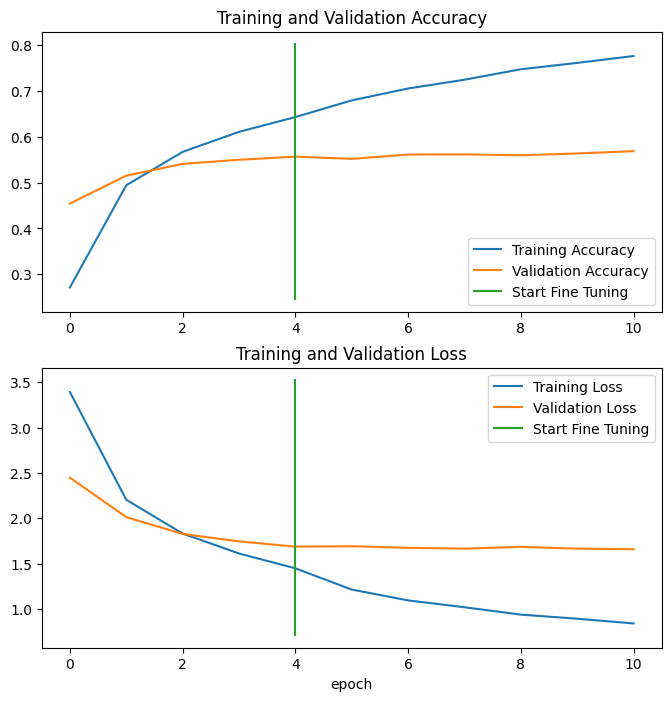

In [21]:
compare_historys(history_1,history_1_fine_tune)

## Evaluating the performance of the big model across all different classes

Let's make some predictions, visualize them and the later find out which prediction were the "most" wrong.

In [30]:
import tensorflow as tf

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip


--2023-08-20 14:57:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.128, 142.250.97.128, 142.251.107.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   136MB/s    in 0.3s    

2023-08-20 14:57:42 (136 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [31]:
unzip_data("06_101_food_class_10_percent_saved_big_dog_model.zip")

In [33]:
model = tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [35]:
# Evaluate the loaded model

results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 69s 87ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027206659317017, 0.6077623963356018]

In [36]:
## Making predictions with model
pred_probs = model.predict(test_data, verbose=1)

790/790 [==============================] - 69s 85ms/step


In [37]:
pred_probs.shape

(25250, 101)

In [42]:
# Let's see what first prediction looks like
pred_probs[0].argmax()

52

In [44]:
pred_classes = pred_probs.argmax(axis=1)

In [45]:
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [46]:
len(pred_classes)

25250

In [47]:
# To get our test_labels we need to unravel our test_Data Batch_dataset
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [49]:
len(y_labels)

25250

In [50]:
results_downloaded_model

[1.8027206659317017, 0.6077623963356018]

In [51]:
# Let's try sckit-learn's accuracy score function and see qhat it comes up with
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_true=y_labels,
                                  y_pred=pred_classes)
sklearn_accuracy

0.6077623762376237

## Let's get visual: Making a confusion matrix


In [60]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed (plot x-labels vertically) ###
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [61]:
# get a list of class names
class_names = test_data.class_names
class_names[10]

'bruschetta'

In [62]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20)

## Let's keep the evaluation train going, time for a classification report

Scikit-learn has a helpful function for acquring many different classification metrics per class (e.g. precision, recall and F1) called classification_report

In [63]:
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [64]:
# get a dictionary of the classification report
classification_report_dict = classification_report(y_true=y_labels,
                                                  y_pred=pred_classes,
                                                   output_dict=True)

## Let's plot all of our classes F1-scores

In [68]:
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report dictionary items
for k,v in classification_report_dict.items():
  if k == "accuracy":
    break
  else:
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [73]:
# Turn f1-score into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)
f1_scores.head()

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008

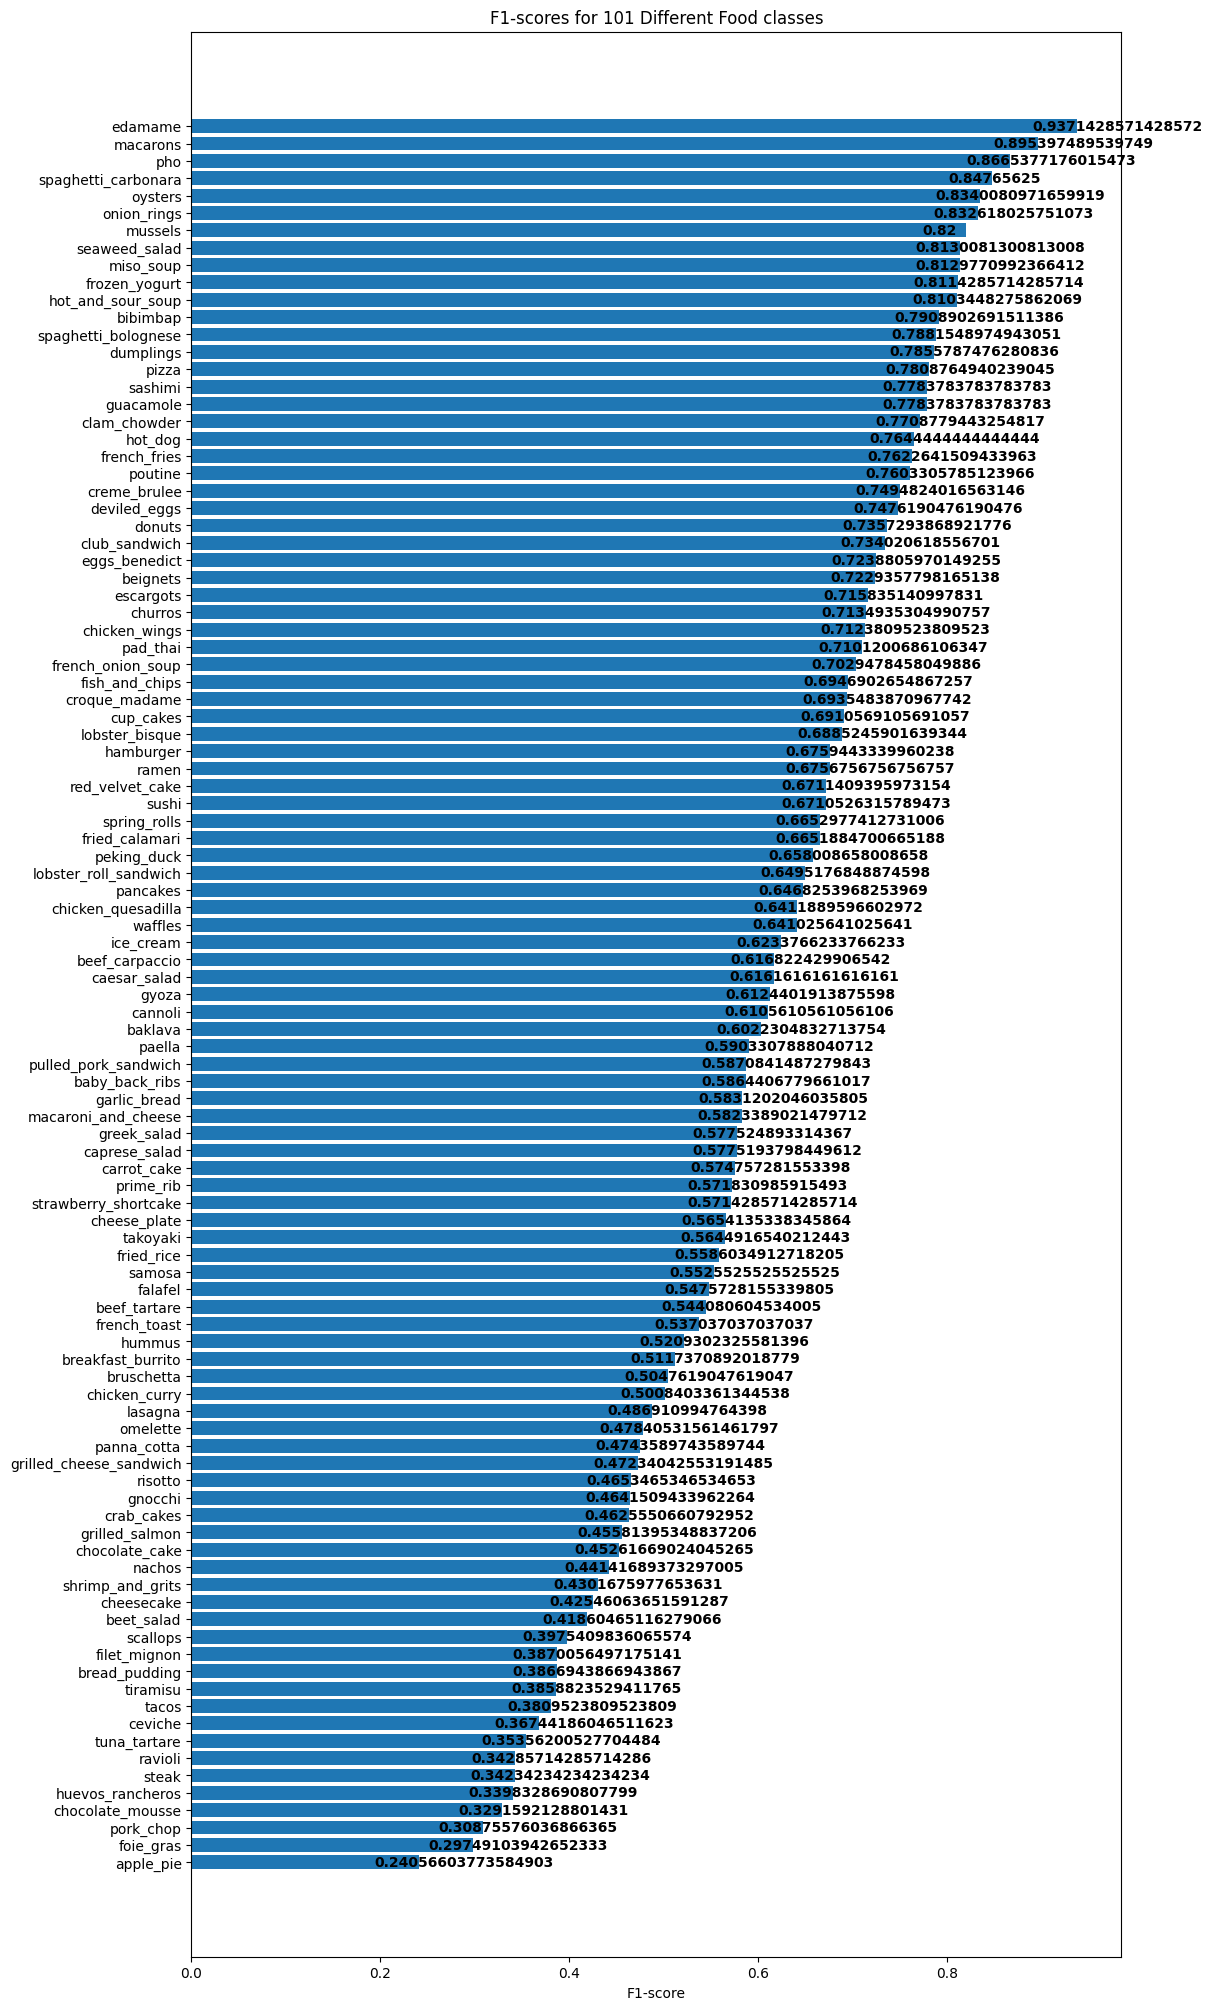

In [81]:
fig,ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_scores)),f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food classes")
ax.bar_label(scores, f1_scores["f1-score"].values,
                  padding=-32, color='black', fontweight='bold')
ax.invert_yaxis();

## Visualizing predictions on custom images

Now this is the real test, how does our model go on food images not even in our test dataset (images of our own).

To visualize our model's predictions on our own images, we'll need a function to load and preprocess
* Read in a target image filepath using
tf.io.read_file()
* Turn the image into a tensor using tf.io.decode_image()
* Resize the image tensor to be the same size as the images our model has trained on using tf.image.resize()
* Scale the image to get all of the pixel values between 0 & 1 (if necessary)

In [82]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_size=224, scale=True):
  """
  Reads in an image from filename, turn it into a tensor and reshapes
  into specified shape (img_shape, img_shape, color_channels=3).

  Args:
    filename (str): path to target image
    image_shape (int): height/width dimension of target image size
    scale (bool): scale pixel values from 0-255 to 0-1 or not

  Returns:
    Image tensor of shape (img_shape,img_shape,3)
  """
  # Read the image
  img = tf.io.read_file(filename)

  # decode image into tensor
  img = tf.io.decode_image(img, channels=3)

  # Resize the image
  img = tf.image.resize(img, [img_size,img_size])

  # Scale? yes/no
  if scale:
    # Rescale the image
    return img/255
  else:
    return img

1/1 [==============================] - 0s 43ms/step


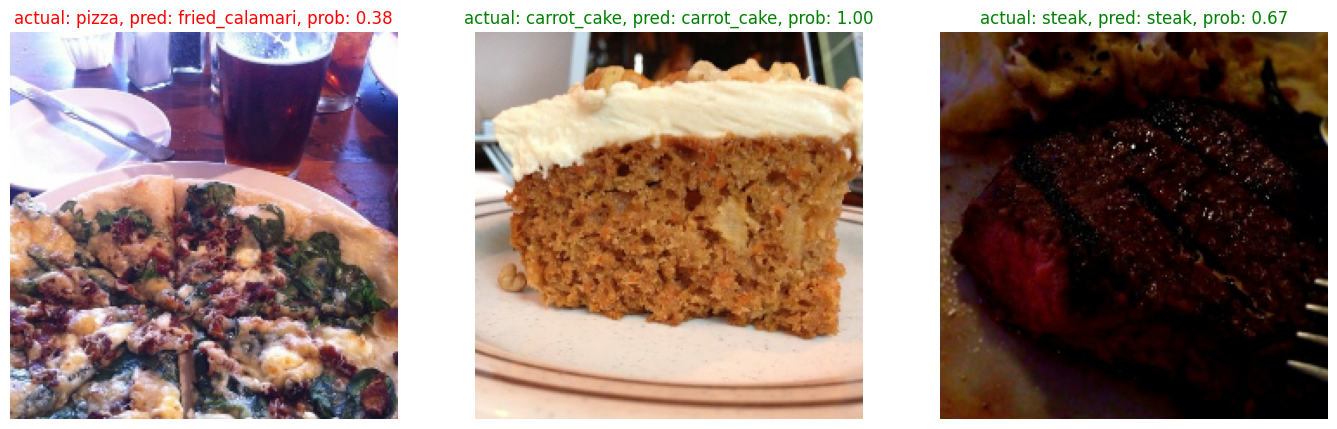

In [92]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17,10))
for i in range(3):
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir+ "/" + class_name))
  filepath = test_dir +"/"+ class_name + "/" + filename

  # Load the image and make prediction
  img = load_and_prep_image(filepath,scale=False)
  pred_prob = model.predict(tf.expand_dims(img,axis=0))
  pred_class = class_names[pred_prob.argmax()]


  # Plot the image(s)
  plt.subplot(1,3,i+1)
  plt.imshow(img/255)
  if class_name == pred_class:
    title_color = 'g'
  else:
    title_color = "r"

  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

In [ ]:
t